# wineデータセットを機械学習で分類する
* データの綺麗、汚さは問わず、整形は標準化だけを行う
* まずはパラメータ調整をせずに学習させる
* 複数のモデルを同時に学習して可視化で比較をする
* 比較後、交差検定とhyperoptによりパラメータ調整を行う

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED=71

## 1. データの読み込みと確認

In [3]:
from sklearn import datasets

#データの読み込み
#iris = datasets.load_iris()
wine = datasets.load_wine()

X = wine.data
Y = wine.target

In [9]:
df = pd.DataFrame(X)
df_y = pd.DataFrame(Y)
df_all = pd.concat([df, df_y], axis=1)

#データの型の確認
df_all.info()

#データの型の確認
type(df_all)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
0     178 non-null float64
1     178 non-null float64
2     178 non-null float64
3     178 non-null float64
4     178 non-null float64
5     178 non-null float64
6     178 non-null float64
7     178 non-null float64
8     178 non-null float64
9     178 non-null float64
10    178 non-null float64
11    178 non-null float64
12    178 non-null float64
0     178 non-null int64
dtypes: float64(13), int64(1)
memory usage: 19.5 KB


pandas.core.frame.DataFrame

In [7]:
#データの件数や統計量を確認
df_all.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,0
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [10]:
df_all.columns = ['アルコール','リンゴ酸','灰','灰のアルカリ性','マグネシウム',
                   'フェノール類全量','フラバノイド','非フラバノイドフェノール類','プロアントシアニン',
                   '色彩強度','色調','蒸留ワインのOD280/OD315','プロリン','ワインの等級']
df_all.head(5)

,アルコール,リンゴ酸,灰,灰のアルカリ性,マグネシウム,フェノール類全量,フラバノイド,非フラバノイドフェノール類,プロアントシアニン,色彩強度,色調,蒸留ワインのOD280/OD315,プロリン,ワインの等級
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 2.データの各カラムの傾向を確認する
* Seabornの可視化機能を利用する

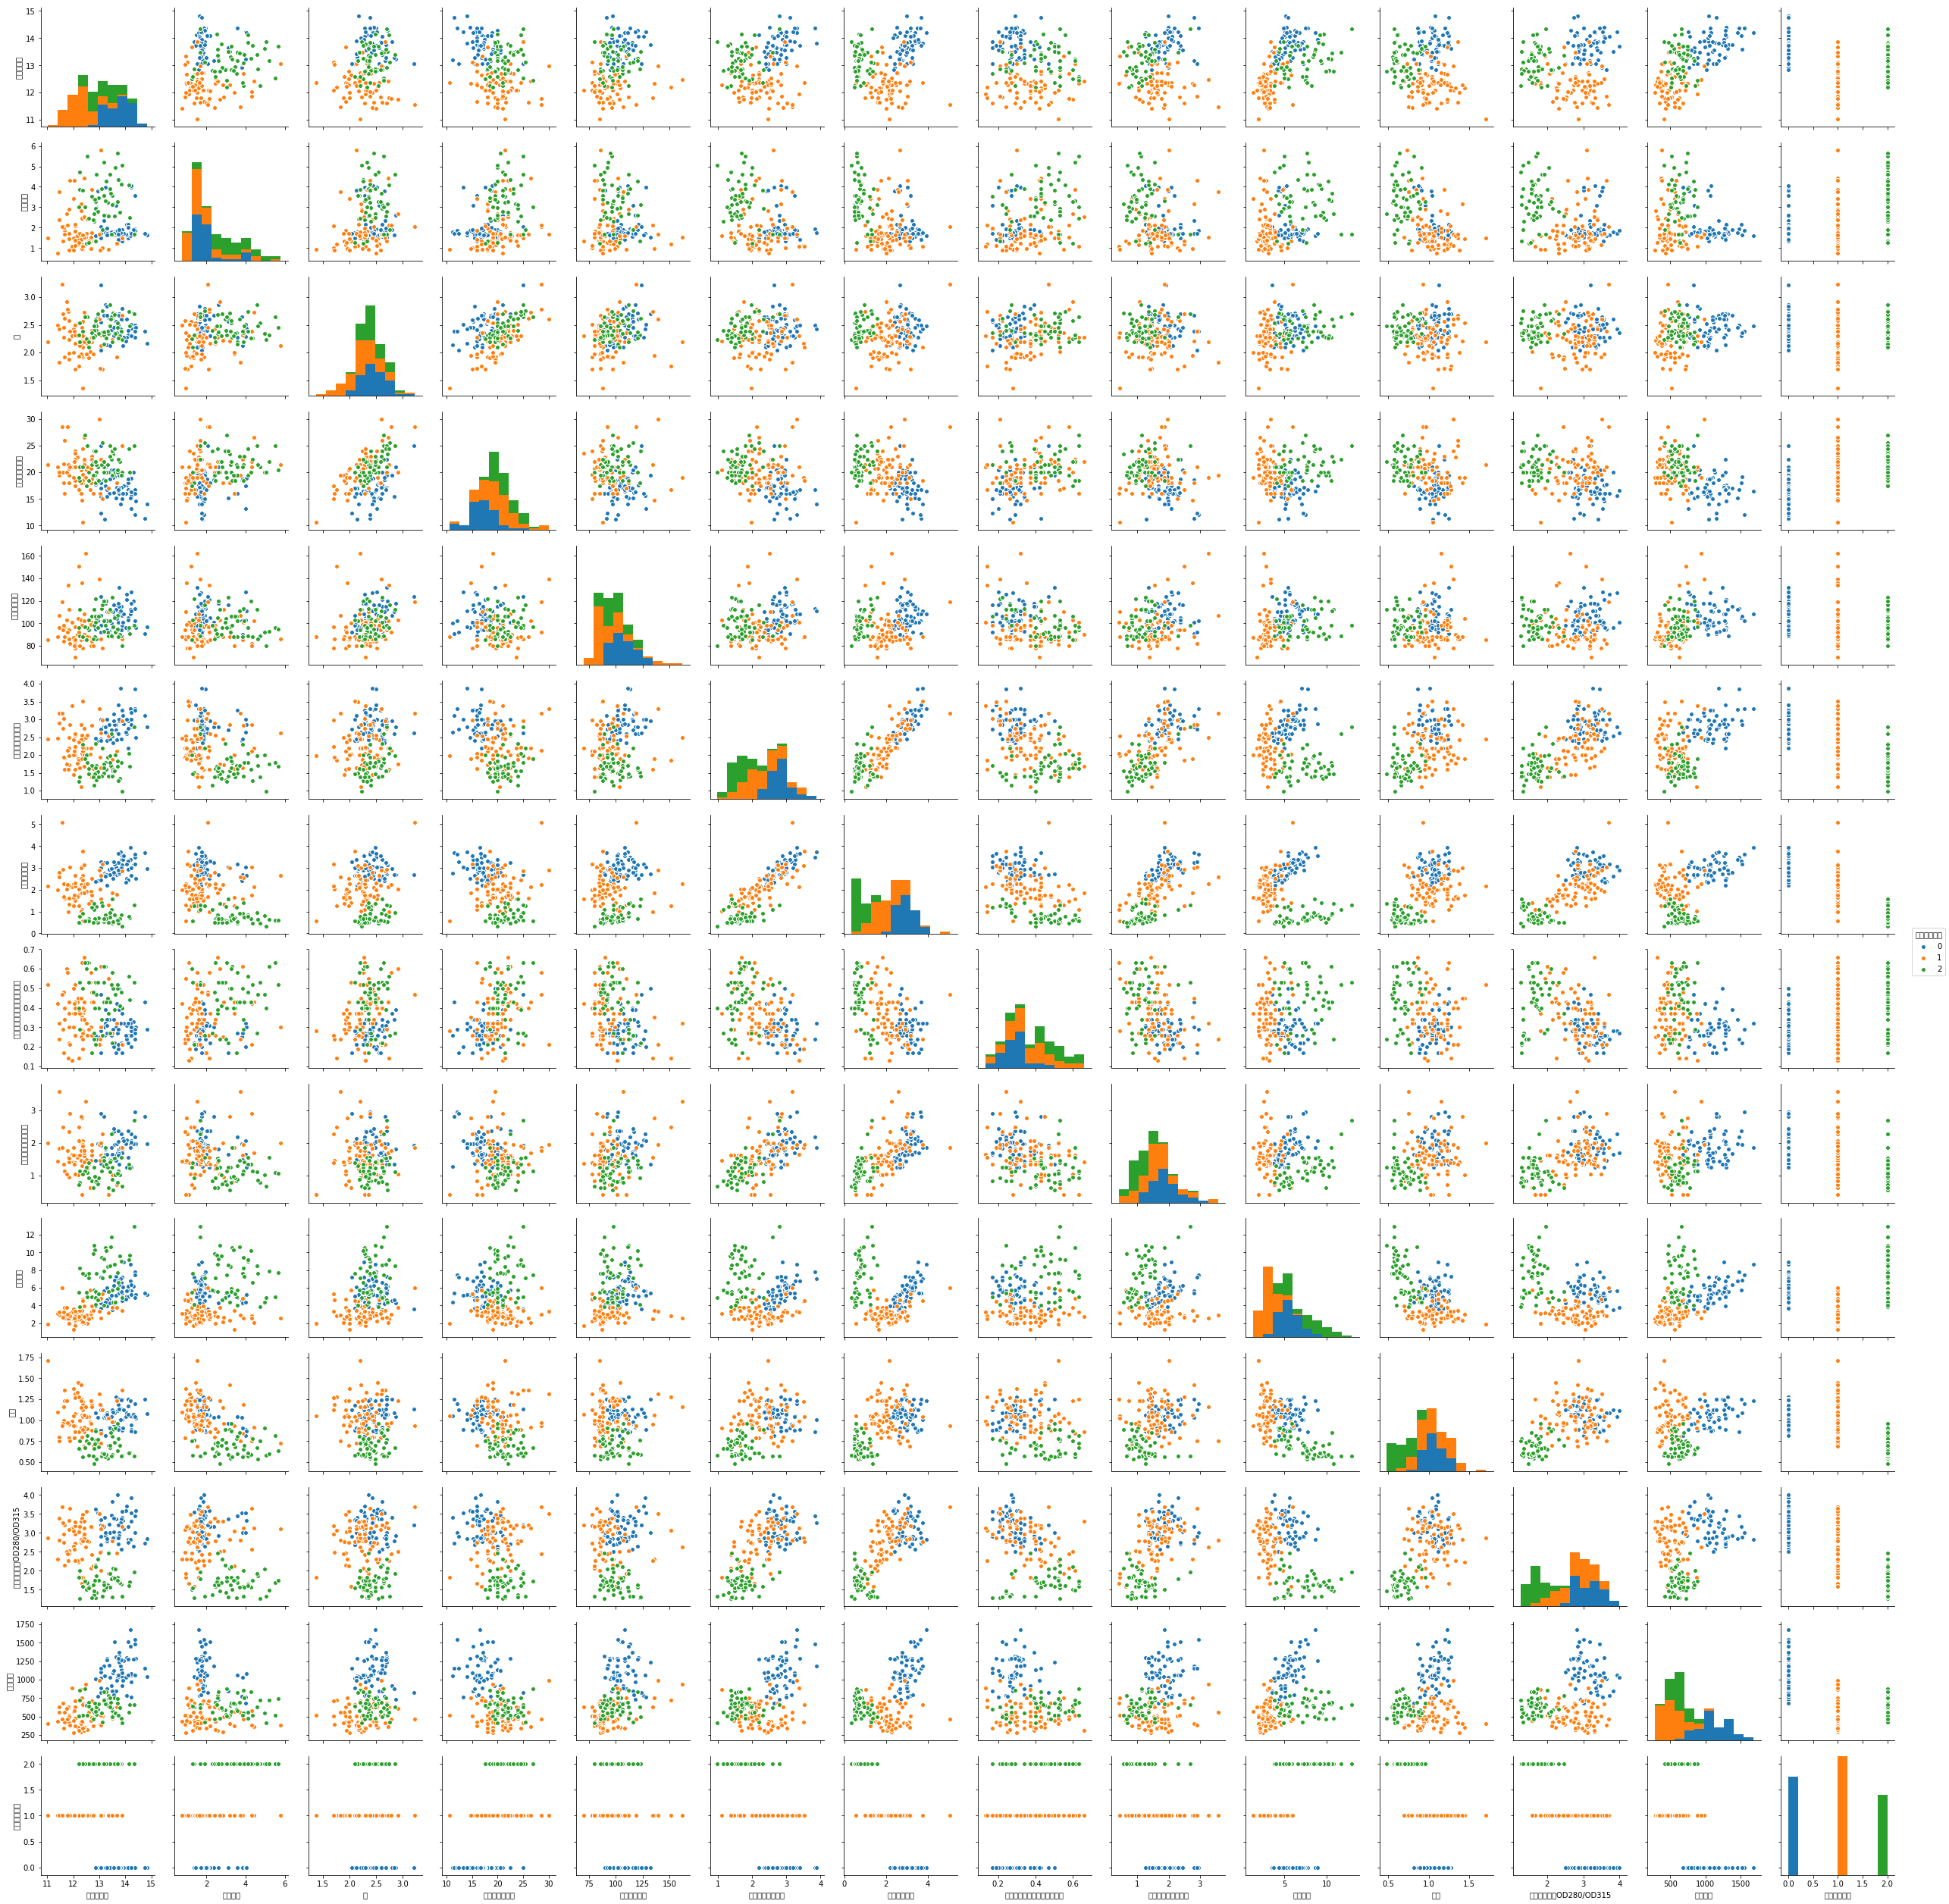

In [11]:
import seaborn as sns

sns.pairplot(df_all, hue='ワインの等級');
plt.show()

## 3.試しに2値での分類モデルを作成する
## 相関性の高い2列を抽出する

Top Absolute Correlations
フェノール類全量           フラバノイド    0.864564
フラバノイド             ワインの等級    0.847498
蒸留ワインのOD280/OD315  ワインの等級    0.788230
dtype: float64


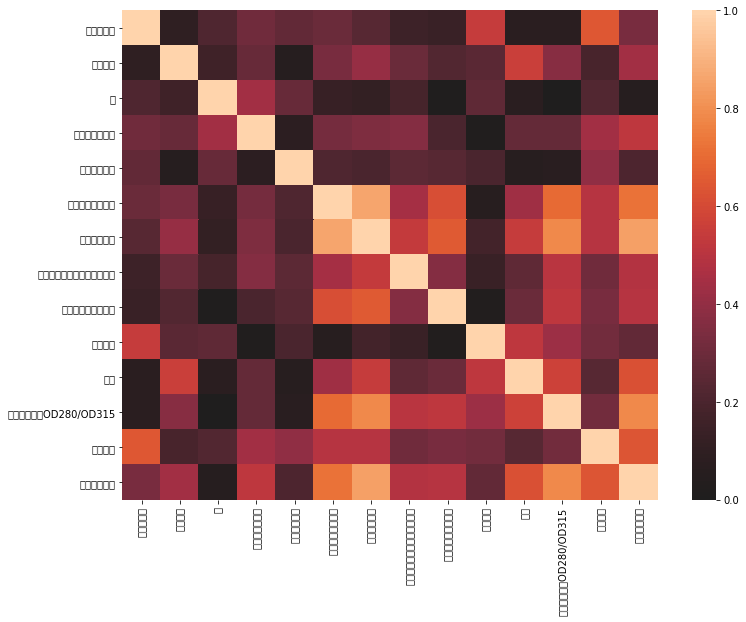

In [12]:
# 前列に可視化をかけても、相関係数が高いのがわからない

import matplotlib.pyplot as plt
df_corr = df_all.corr()

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

df_top_corr = get_top_abs_correlations(df_all, 3)

print("Top Absolute Correlations")
print(df_top_corr)

# Heatmapl可視化
fig = plt.subplots(figsize=(12, 9)) 
# 逆相関のものは絶対値表示で可視化している
sns.heatmap(df_corr.abs(), vmax=1, vmin=0, center=0)

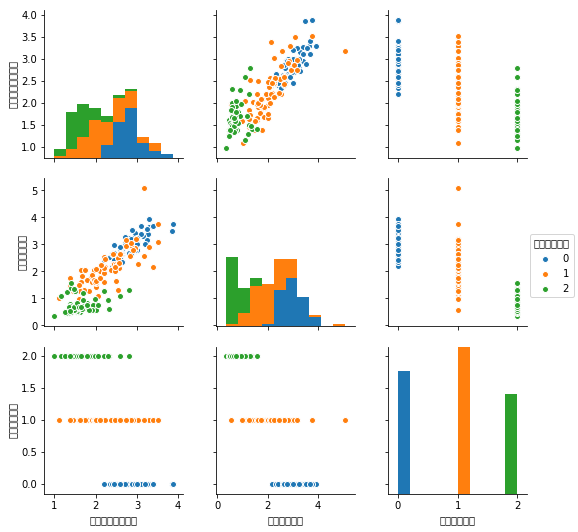

In [13]:
# フェノール類全量 フラバノイド 0.864564
df_new = df_all.loc[:,['フェノール類全量','フラバノイド','ワインの等級']]
sns.pairplot(df_new, hue='ワインの等級');

# 多少は相関性があることが見て取れる

## 4.教師データと試験データの準備、データの前処理

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ['アルコール','リンゴ酸','灰','灰のアルカリ性','マグネシウム',
#  'フェノール類全量','フラバノイド','非フラバノイドフェノール類','プロアントシアニン',
# '色彩強度','色調','蒸留ワインのOD280/OD315','プロリン','ワインの等級']
# [5]フェノール類全量
# [6]フラバノイド

# 今回は２カラムについてのみを対象とする
X = wine.data[:, [5,6]]
y = wine.target
print(pd.DataFrame(X).head())

# トレーニングデータとテストデータに分割。
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)

# データの標準化処理
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

      0     1
0  2.80  3.06
1  2.65  2.76
2  2.80  3.24
3  3.85  3.49
4  2.80  2.69


## 5.モデルの作成と学習
    サンプルでの採用手法
    * ロジスティック回帰
    * SGD(確率的勾配法)
    * 線形SVM、線形カーネル、多項式カーネル、RBFカーネル
    * 二分木、ランダムフォレスト、GDBT

In [15]:
#機械学習モデルのリスト
models=[]

# ロジスティック回帰のインスタンスを生成
from sklearn.linear_model import LogisticRegression
models.append(LogisticRegression(random_state=RANDOM_SEED))

# SGDのインスタンスを生成
from sklearn.linear_model import SGDClassifier
models.append(SGDClassifier(max_iter=1000,random_state=RANDOM_SEED))

# SVMのインスタンスを生成
from sklearn.svm import LinearSVC
models.append(LinearSVC(random_state=RANDOM_SEED)) # 線形SVM
from sklearn.svm import SVC
models.append(SVC(kernel='linear', random_state=RANDOM_SEED))         # 線形カーネル
models.append(SVC(kernel='poly', degree=3, random_state=RANDOM_SEED)) # 多項式カーネル
models.append(SVC(kernel='rbf', gamma=0.7, random_state=RANDOM_SEED)) # RBFカーネル

# 二分木のインスタンスを生成
from sklearn.tree import DecisionTreeClassifier
models.append(DecisionTreeClassifier(random_state=RANDOM_SEED))

# ランダムフォレストのインスタンスを生成
from sklearn.ensemble import RandomForestClassifier
models.append(RandomForestClassifier(random_state=RANDOM_SEED))

# GBDTのインスタンスを生成
from sklearn.ensemble import GradientBoostingClassifier
models.append(GradientBoostingClassifier(random_state=RANDOM_SEED))
##n_estimators=100,learning_rate=0.1, max_depth=3

# モデルの学習。fit関数で行う。
for number, model in enumerate(models):
    # モデルの名前取得
    model_title = str(type(model)).split(".")[-1][:-2]
    print("model : " + model_title + " : " + str(number))
    
    #機械学習モデルのリストに、学習させたモデルを詰める
    models[number] = model.fit(X_train_std, y_train)


model : LogisticRegression : 0
model : SGDClassifier : 1
model : LinearSVC : 2
model : SVC : 3
model : SVC : 4
model : SVC : 5
model : DecisionTreeClassifier : 6
model : RandomForestClassifier : 7
model : GradientBoostingClassifier : 8


## 6.モデルの精度を評価する

In [16]:
from sklearn.metrics import accuracy_score

for model in models:
    print("-------------------------------------------")
    model_title = str(type(model)).split(".")[-1][:-2]
    print("model : " + model_title)

    # トレーニングデータに対する精度
    pred_train = model.predict(X_train_std)
    accuracy_train = accuracy_score(y_train, pred_train)
    print('  トレーニングデータに対する正解率： %.2f' % accuracy_train)

    # テストデータに対する精度
    pred_test = model.predict(X_test_std)
    accuracy_test = accuracy_score(y_test, pred_test)
    print('  テストデータに対する正解率： %.2f' % accuracy_test)

-------------------------------------------
model : LogisticRegression
  トレーニングデータに対する正解率： 0.81
  テストデータに対する正解率： 0.76
-------------------------------------------
model : SGDClassifier
  トレーニングデータに対する正解率： 0.85
  テストデータに対する正解率： 0.69
-------------------------------------------
model : LinearSVC
  トレーニングデータに対する正解率： 0.81
  テストデータに対する正解率： 0.78
-------------------------------------------
model : SVC
  トレーニングデータに対する正解率： 0.82
  テストデータに対する正解率： 0.74
-------------------------------------------
model : SVC
  トレーニングデータに対する正解率： 0.76
  テストデータに対する正解率： 0.69
-------------------------------------------
model : SVC
  トレーニングデータに対する正解率： 0.85
  テストデータに対する正解率： 0.76
-------------------------------------------
model : DecisionTreeClassifier
  トレーニングデータに対する正解率： 1.00
  テストデータに対する正解率： 0.61
-------------------------------------------
model : RandomForestClassifier
  トレーニングデータに対する正解率： 0.97
  テストデータに対する正解率： 0.63
-------------------------------------------
model : GradientBoostingClassifier
  トレーニングデータに対する正解率： 1.00
  テ

## 7.分類結果の可視化

model No.0 : LogisticRegression
model No.1 : SGDClassifier
model No.2 : LinearSVC
model No.3 : SVC
model No.4 : SVC
model No.5 : SVC
model No.6 : DecisionTreeClassifier
model No.7 : RandomForestClassifier
model No.8 : GradientBoostingClassifier


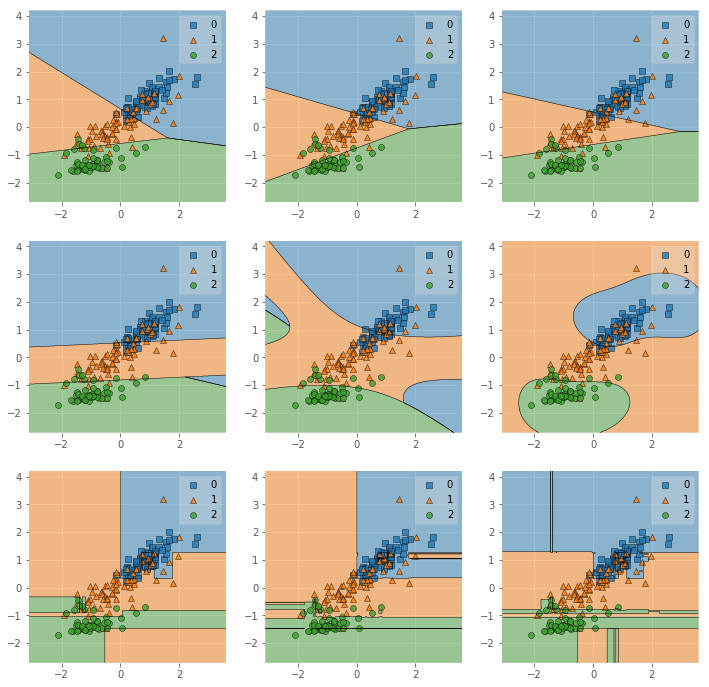

In [17]:
#分類結果を図示する
import matplotlib.pyplot as plt

# scikit-laernやmatplotlibに含まれない機能を含むPythonライブラリ
from mlxtend.plotting import plot_decision_regions
plt.style.use('ggplot') 

#配列データの結合（教師データ＋試験データ）
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

# 可視化
fig = plt.figure(figsize=(12,12))

for number, model in enumerate(models):
    
    # 表示するモデル数に合わせて、ここの変数を変更してあげる必要あり
    plt.subplot(3, 3, number+1)

    # model名の取得
    # <class 'sklearn.linear_model.logistic.LogisticRegression'>
    # -> LogisticRegression
    model_title = str(type(model)).split(".")[-1][:-2]#[:-len("Classifier")]
    print("model No." + str(number) + " : " + model_title)

    # 分類器の決定境界を引いてくれる神機能(mlxtendに含まれる機能の１つ)
    # データとターゲット，分類器を渡すだけで描いてくれる
    plot_decision_regions(X_combined_std, y_combined, clf=model,  res=0.02)
plt.show()

## 8.交差検定とHyperoptによりパラメータ調整をする